### (PSL) Coding Assignment 3

#### Member
| Field         | Value                |
|---------------|----------------------|
| Name          | Lee Yu Chung, Paul   |
| UID           | 665451160            |
| NetID         | ycl7                 |
| Program       | MCS-DS               |
| Contributions | 100%                 |



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set random seed
np.random.seed(1160)

/home/lycpaul/anaconda3/envs/dl/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# import the data
# consisted of 506 rows (i.e., n = 506) and 14 columns: Y, X1 through X13. No col and row index.
url = "./Coding3_Data.csv"
data = pd.read_csv(url)
print(data.head())
print(data.info())

          x         y
0  0.009496  2.692822
1  0.039996  0.566787
2  0.045770 -0.133373
3  0.113703 -2.696734
4  0.159046 -0.145285
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       30 non-null     float64
 1   y       30 non-null     float64
dtypes: float64(2)
memory usage: 608.0 bytes
None


### Part I: Optimal span for LOESS

1. Write a function to retrieve the Diagonal of the Smoother Matrix. We’re only interested in the
diagonal entries (which will be used in computing LOO-CV and GCV), so this function should return
an n-by-1 vector.
- Inputs: x (an n-by-1 feature vector) and span (a numerical value).
- Output: n-by-1 vector representing the diagonal of the smoother matrix S.
- If you’re using R, please refer to the technique we used for computing the smoother matrix in
smoothing spline models and adapt it for LOESS.
- If you’re using Python, you can either use the aforementioned technique or directly retrieve the
diagonal entries from the output of skmisc.loess [Link]. Keep in mind that the input to this
function should only be x and span, not y. When calling skmisc.loess to retrieve the diagonal
entries, you can use a fake y vector, as the diagonal entries remain the same and do not depend on
the response vector y.

In [3]:
from skmisc.loess import loess

def get_smoother_matrix_diagonal(x: np.ndarray, span: float) -> np.ndarray:
    """Retrieve the diagonal of the smoother matrix.

    Args:
        x (np.ndarray): x (an n-by-1 feature vector) and span (a numerical value).
        span (float): The span parameter for the LOESS model.

    Returns:
        np.ndarray: n-by-1 vector representing the diagonal of the smoother matrix S.
    """
    y = np.zeros_like(x)    
    model  = loess(x, y, span=span)
    model.fit()
    diagonal = model.outputs.diagonal   
    return diagonal


In [4]:
# Testing the smoother matrix diagonal function
x = data['x'].values
span = 0.5
diagonal = get_smoother_matrix_diagonal(x, span)

print(x[:5], "\n", x.shape)
print(diagonal[:5], "\n", diagonal.shape)

[0.00949576 0.03999592 0.04577026 0.11370341 0.159046  ] 
 (30,)
[0.61799136 0.2677504  0.25250909 0.33892068 0.27303055] 
 (30,)


2. Write a function to find the Optimal Span(s) based on CV and GCV.
- Iterate over the speciﬁed span values.
- For each span, calculate the CV and GCV values.
- Return the CV and GCV values corresponding to each span.
- Determine the best span(s) based on the CV and GCV results.

In [5]:
def find_optimal_span(x: np.ndarray, y: np.ndarray, spans: np.ndarray) -> tuple:
    """Find the optimal span based on CV and GCV.

    Args:
        x (np.ndarray): Input features (n-by-1 vector).
        y (np.ndarray): Target values (n-by-1 vector).
        spans (np.ndarray): Array of span values to evaluate.

    Returns:
        tuple: (cv_values, gcv_values, best_span_cv, best_span_gcv)
            cv_values: List of CV values for each span.
            gcv_values: List of GCV values for each span.
            best_span_cv: Optimal span based on CV.
            best_span_gcv: Optimal span based on GCV.
    """
    n = len(x)
    cv_values = []
    gcv_values = []

    for span in spans:
        S_diag = get_smoother_matrix_diagonal(x, span)
        
        # Fit LOESS model
        model = loess(x, y, span=span)
        model.fit()
        y_pred = model.predict(x).values
        residual = y - y_pred
        
        # Calculate CV
        cv = np.mean((residual / (1 - S_diag))**2)
        cv_values.append(cv)

        # Calculate GCV
        gcv = np.mean((residual / (1 - np.mean(S_diag)))**2)
        gcv_values.append(gcv)

    best_span_cv = spans[np.argmin(cv_values)]
    best_span_gcv = spans[np.argmin(gcv_values)]

    return cv_values, gcv_values, best_span_cv, best_span_gcv


3. Test your code using the provided dataset [Coding3_Data.csv].
- Report your CV and GCV for the following 15 span values: 0.20, 0.25, . . . , 0.90.
- Determine the best span value based on the CV and GCV results. For this dataset, both methods
recommend the same span.

CV values: [12.415910699873358, 2.241473495890156, 1.5029798111583719, 1.2591747084691487, 1.1903799279913372, 1.156812123062569, 1.1256523403714558, 1.179663752374439, 1.1794641625428175, 1.250913827381304, 1.553562264253347, 1.6361746170729456, 1.7645336266044531, 1.9760935148587322]
GCV values: [2.110161841942956, 1.4892056326217187, 1.1901098446318241, 1.1744229564766882, 1.1025399038231014, 1.0625034645069504, 1.04183287861128, 1.1188405514998319, 1.1192688072551904, 1.1805847769313849, 1.5190908128135596, 1.6274293455726156, 1.7445490858435326, 1.92569596135356]
Best span (CV): 0.50
Best span (GCV): 0.50


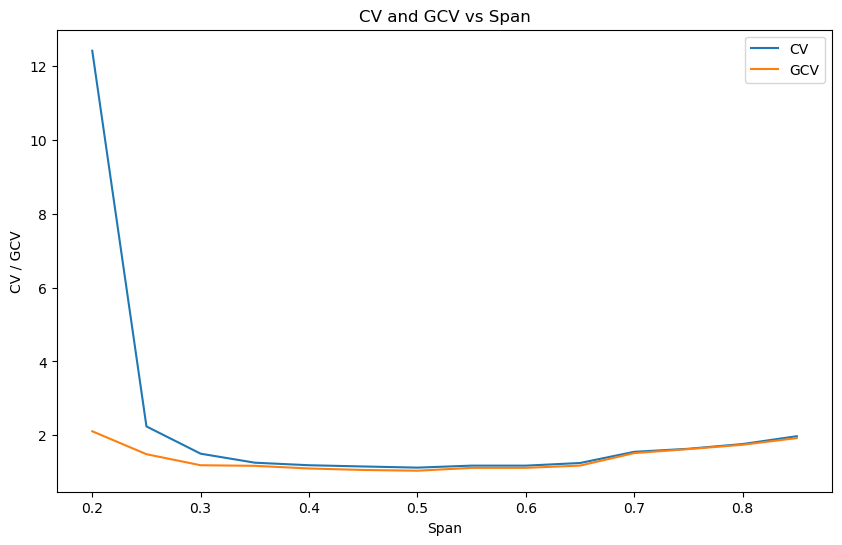

In [26]:
# Searching the optimal span
# spans [0.2, 0.9], 0.05 interval
spans = np.arange(0.2, 0.9, 0.05)
x = data['x']
y = data['y']

cv_values, gcv_values, best_span_cv, best_span_gcv = find_optimal_span(x, y, spans)

# set print precision to 4
print(f"CV values: {cv_values}")
print(f"GCV values: {gcv_values}")
print(f"Best span (CV): {best_span_cv:.2f}")
print(f"Best span (GCV): {best_span_gcv:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(spans, cv_values, label='CV')
plt.plot(spans, gcv_values, label='GCV')
plt.xlabel('Span')
plt.ylabel('CV / GCV')
plt.title('CV and GCV vs Span')
plt.legend()
plt.show()

assert(best_span_cv == best_span_gcv)

- Fit a LOESS model over the entire dataset using the selected optimal span.
- Display the original data points and overlay them with the true curve and the ﬁtted curve. Include a legend to distinguish between the two curves.
- The true curve is
$$
f(x) = \frac{\sin(12(x + 0.2))}{x + 0.2}, \quad x \in [0, 1].
$$
- Note: To display a smooth curve, evaluate your function on a ﬁner grid of points and then plot those points. Your plot may diﬀer from the one shown below, and you are encouraged to use your own color schemes and styles.

In [28]:
# the true curve
def f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)

fx = np.arange(1, 51, 1)/50
fy = f(fx)

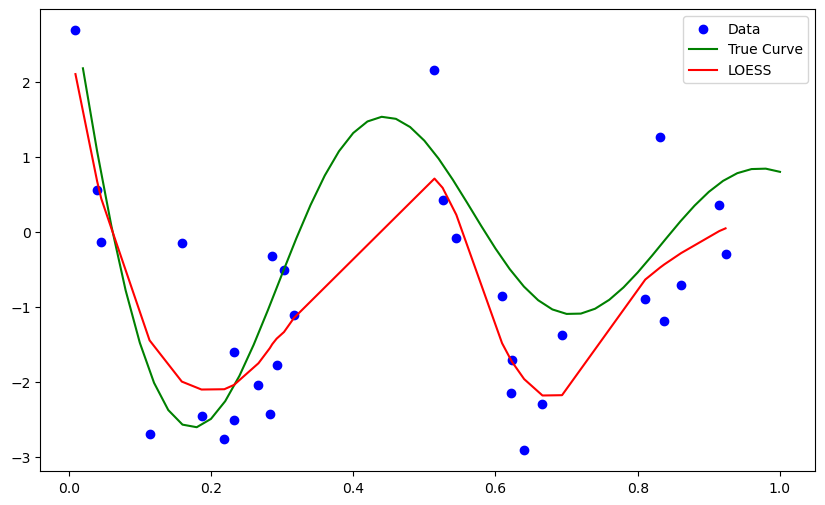

In [29]:
# Using the optimal span to fit the model
model = loess(x, y, span=best_span_cv)
model.fit()
y_pred = model.predict(x).values

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', color='blue')
plt.plot(fx, fy, label='True Curve', color='green')
plt.plot(x, y_pred, label='LOESS', color='red')
plt.legend()
plt.show()


### Part II: Ridgeless and double d

### Part III: Clustering time series